In [1]:
import numpy as np
import networkx as nx
import json
from networkx.readwrite import json_graph

In [29]:
from matplotlib import pyplot as plt

In [43]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4

In [90]:
import os

In [2]:
graph_data = json.load(open("/home/gear/data/ppi/ppi-G.json"))

In [3]:
G = json_graph.node_link_graph(graph_data)

In [4]:
len(G)

56944

### Get the number connected components and a mapping for separated graphs

In [5]:
num_connected_components = nx.number_connected_components(G)
connected_components_subgraphs = nx.connected_component_subgraphs(G)

print("Number of connected components: ", num_connected_components)

Number of connected components:  295


In [6]:
type(connected_components_subgraphs)

generator

In [7]:
connected_components_subgraphs = [g for g in connected_components_subgraphs]

In [8]:
connected_components_subgraphs[0].node[0]

{'test': False, 'val': False}

In [10]:
test_graphs = []
val_graphs = []
train_graphs = []
for i, g in enumerate(connected_components_subgraphs):
    test = 'not set'
    val = 'not set'
    for node_id in g.nodes():
        if test == 'not set' and val == 'not set':
            test = str(g.node[node_id]['test'])
            val = str(g.node[node_id]['val'])
        if str(g.node[node_id]['test']) != test or str(g.node[node_id]['val']) != val:
            print("Inconsistent in val-test marker for graph index {}".format(i))
    if test == 'True' and val == 'False':
        test_graphs.append(g)
    if test == 'False' and val == 'True':
        val_graphs.append(g)
    if test == 'False' and val == 'False':
        train_graphs.append(g)
    if test == 'True' and val == 'True':
        print("Something is really wrong.")

The cell above doesn't print val-test warning means that the data is correct: Each whole connected component is a test/val/train.

In [11]:
len(test_graphs)

30

In [12]:
len(val_graphs)

30

In [13]:
len(train_graphs)

235

In [25]:
for i, tg in enumerate(test_graphs):
    if len(tg) > 1:
        print(i, len(tg))

0 3194
8 2
15 2
19 2300


In [27]:
for i, vg in enumerate(val_graphs):
    if len(vg) > 1:
        print(i, len(vg))

0 3195
4 2
5 2
9 2
13 3284
20 2
22 2
23 2
25 2


In [28]:
for i, tg in enumerate(train_graphs):
    if len(tg) > 1:
        print(i, len(tg))

0 1546
9 1377
12 2
20 2263
31 2339
42 1578
52 1021
61 1823
74 2488
87 591
99 3312
103 2
105 2
112 2401
119 1878
126 1819
133 3480
141 2
150 2794
164 2326
172 2650
187 2815
202 3163
208 2
213 2
218 3021


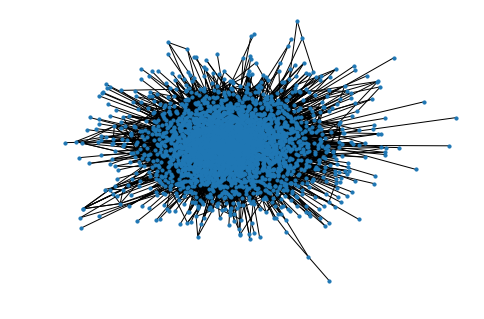

In [37]:
nx.draw_spring(test_graphs[0], node_color='C0', node_size=10, figsize=(20,15), dpi=300)
plt.show()

In [47]:
def interactive_graph(graph, name='unamed_plot'):
    plot = Plot(plot_width=800, plot_height=800,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = "Graph {}".format(name)
    plot.add_tools(BoxZoomTool(), ResetTool())
    graph_renderer = from_networkx(graph, nx.spring_layout, scale=1, center=(0, 0))
    graph_renderer.node_renderer.glyph = Circle(size=8, fill_color=Spectral4[0])
    graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
    plot.renderers.append(graph_renderer)
    output_file(name+".html")
    show(plot)

### Adding noise to the feature vectors 

In [52]:
ppi_features = np.load("/home/gear/data/ppi/ppi-feats.npy")

In [53]:
len(ppi_features)

56944

In [54]:
ppi_features.shape

(56944, 50)

In [62]:
sum(ppi_features)

array([ 417.,  432.,  717., 1627.,  336.,  564.,  322.,  731.,  826.,
        562.,    0., 1602.,  106.,  701.,  323.,  741.,  596.,  712.,
       1142.,  535.,  426., 1173.,  852.,  866.,  548.,  799.,  755.,
        301.,  246.,  424., 1771., 1164., 1405., 1387., 1209., 9002.,
       1432., 1335., 1278., 1087.,  933., 1310., 1411., 1324., 1185.,
       1160., 1349., 1076., 1247., 1233.])

In [63]:
zero_feature_count = 0
for f in ppi_features:
    if sum(f) == 0:
        zero_feature_count += 1
print("Number of nodes with zero features: ", zero_feature_count)

Number of nodes with zero features:  24211


In [64]:
zero_feats_test_count = 0
zero_feats_val_count = 0
zero_feats_train_count = 0
for i, f in enumerate(ppi_features):
    if sum(f) == 0:
        if G.node[i]['test']:
            zero_feats_test_count += 1
        elif G.node[i]['val']:
            zero_feats_val_count += 1
        else:
            zero_feats_train_count += 1
print("Test, val, train zero features count: ", zero_feats_test_count, zero_feats_val_count, zero_feats_train_count)

Test, val, train zero features count:  2377 2826 19008


In [65]:
test_count = 0
val_count = 0
train_count = 0
for i in G.nodes():
    if G.node[i]['test']:
        test_count += 1
    elif G.node[i]['val']:
        val_count += 1
    else:
        train_count += 1

In [66]:
print("Test, val, train total node count: ", test_count, val_count, train_count)

Test, val, train total node count:  5524 6514 44906


In [67]:
2377 / 5524

0.43030412744388125

In [68]:
2826 / 6514

0.433834817316549

In [69]:
19008 / 44906

0.4232841936489556

A few functions to corrupt a single 1-d feature array

In [73]:
for (i, j) in np.random.choice([1,2,3,4,5,6,7,8,9,0], size=(5,2), replace=True):
    print(i,j)

2 5
1 8
6 3
6 4
8 1


In [77]:
def random_swap(arr, noise_rate=0.1):
    assert 0.0 <= noise_rate <= 1.0, "Really?"
    n = len(arr)
    count = int(n *noise_rate)
    if n < 2*count:
        rpl = True
    else:
        rpl = False
    swap_pairs = np.random.choice(range(n), size=(count, 2), replace=rpl)
    for (i, j) in swap_pairs:
        t = arr[i]
        arr[i] = arr[j]
        arr[j] = t
    return arr

In [89]:
def gaussian_noise(arr, mean=0.0, std=1.0):
    arr = np.array(arr, dtype=float)
    arr = arr + np.random.normal(mean, std, size=arr.shape)
    return arr

In [101]:
test = np.array([[1,2,3,4,5], [6,7,8,9,0]])

In [100]:
t = lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.5), 1, aa)

In [102]:
t(test)

array([[5, 4, 3, 2, 1],
       [9, 0, 8, 6, 7]])

In [103]:
test

array([[5, 4, 3, 2, 1],
       [9, 0, 8, 6, 7]])

In [93]:
def corrupt_features(path_to_file, noise_func, name):
    org_features = np.load(path_to_file)
    new_features = noise_func(org_features)
    new_name, ext = os.path.splitext(path_to_file)
    new_name = new_name + name + ext
    np.save(new_name, new_features)
    print("Saved new features set at {}".format(new_name))

In [108]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.2), 1, aa),
                 "-random_swap_0.2")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.2.npy


In [109]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.3), 1, aa),
                 "-random_swap_0.3")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.3.npy


In [110]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.35), 1, aa),
                 "-random_swap_0.35")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.35.npy


In [111]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.4), 1, aa),
                 "-random_swap_0.4")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.4.npy


In [112]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.45), 1, aa),
                 "-random_swap_0.45")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.45.npy


In [113]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.5), 1, aa),
                 "-random_swap_0.5")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.5.npy


In [114]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.55), 1, aa),
                 "-random_swap_0.55")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.55.npy


In [115]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.6), 1, aa),
                 "-random_swap_0.6")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.6.npy


In [116]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.65), 1, aa),
                 "-random_swap_0.65")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.65.npy


In [117]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.7), 1, aa),
                 "-random_swap_0.7")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.7.npy


In [121]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.25), 1, aa),
                 "-random_swap_0.25")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.25.npy


In [122]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.15), 1, aa),
                 "-random_swap_0.15")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.15.npy


In [123]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.1), 1, aa),
                 "-random_swap_0.1")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.1.npy


In [124]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.75), 1, aa),
                 "-random_swap_0.75")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.75.npy


In [125]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.8), 1, aa),
                 "-random_swap_0.8")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.8.npy


In [126]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.85), 1, aa),
                 "-random_swap_0.85")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.85.npy


In [127]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.9), 1, aa),
                 "-random_swap_0.9")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.9.npy


In [128]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.95), 1, aa),
                 "-random_swap_0.95")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.95.npy
